<h1><font color='red'>This notebook is in development and not ready for public testing. </font></h1>

# q3dfit example notebook: rest frame optical, Gemini+GMOS data of PG1411+442

<h3><font color='teal'>Installation of the environment and the package are described <a href="https://q3dfit.readthedocs.io/">here</a>. </font></h3>

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.0. Setting up the directory tree](#chapter1_0)
    * [1.1. Setting up the data and models](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)
        * [1.2.3. Line ratio constraints](#chapter1_2_3)
    * [1.3. Setting up the plotting parameters](#chapter1_3)
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np

In [2]:
# Convenience function
# Ref: https://github.com/spacetelescope/jwebbinar_prep/blob/main/imaging_mode/imaging_mode_stage_1.ipynb
from astropy.utils.data import download_file
def download_files(files, output_directory, force=False):
    """Given a tuple or list of tuples containing (URL, filename),
    download the given files into the current working directory.
    Downloading is done via astropy's download_file. A symbolic link
    is created in the specified output dirctory that points to the
    downloaded file.
    
    Parameters
    ----------
    files : tuple or list of tuples
        Each 2-tuple should contain (URL, filename), where
        URL is the URL from which to download the file, and
        filename will be the name of the symlink pointing to
        the downloaded file.
        
    output_directory : str
        Name of the directory in which to create the symbolic
        links to the downloaded files
        
    force : bool
        If True, the file will be downloaded regarless of whether
        it is already present or not.
                
    Returns
    -------
    filenames : list
        List of filenames corresponding to the symbolic links
        of the downloaded files
    """
    # In the case of a single input tuple, make it a
    # 1 element list, for consistency.
    filenames = []
    if isinstance(files, tuple):
        files = [files]
        
    for file in files:
        filenames.append(file[1])
        if force:
            print('Downloading {}...'.format(file[1]))
            demo_file = download_file(file[0], cache='update')
            # Make a symbolic link using a local name for convenience
            if not os.path.islink(os.path.join(output_directory, file[1])):
                os.symlink(demo_file, os.path.join(output_directory, file[1]))
        else:
            if not os.path.isfile(os.path.join(output_directory, file[1])):
                print('Downloading {}...'.format(file[1]))
                demo_file = download_file(file[0], cache=True)
                # Make a symbolic link using a local name for convenience
                os.symlink(demo_file, os.path.join(output_directory, file[1]))
            else:
                print('{} already exists, skipping download...'.format(file[1]))
                continue
    return filenames    


### 1.0. Setting up the directory tree <a class="anchor" id="chapter1_0"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. Then download test data.

In [3]:
# book-keeping variables
volume = 'pg1411/' # base directory
gal = 'pg1411' # prefix label for output files
# Output directories/files
outdir = volume # path + name of directory for saving the output files
path_to_npy_file = volume # path for initproc.npy
logfile = outdir+gal+'-fitlog.txt'

Download data from public Box folder:

In [4]:
# make subdirectory to hold data
if not os.path.exists('pg1411'):
    os.makedirs('pg1411')
# make tuples of urls and download filenames
# infile = 3x3 (spatially) binned data cube
# qsotempfits = unbinned data cube; use central spaxel as QSO spectral template
# stellartemplates = stellar host galaxy model, derived using method in Rupke et al. 2017
infile_tup=('https://rhodes.box.com/shared/static/d5d9smfhxk8douhdoy0id9tqu7ujccgg.fits','pg1411-gmos-rebin.fits')
qsotempfits_tup=('https://rhodes.box.com/shared/static/torucoo1uq8npouc7moi060rzuja26wz.fits','pg1411-gmos.fits')
stellartemplates_tup=('https://rhodes.box.com/shared/static/3l5q91aqxwo8l42z88btd0fl988gbhd4.npy','pg1411-stellar-model.npy')
# download files; force overwrite and take first element of output
infile = download_files(infile_tup, outdir, force=True)[0]
qsotempfits = download_files(qsotempfits_tup, outdir, force=True)[0]
stellartemplates = download_files(stellartemplates_tup, outdir, force=True)[0]
# add subdirectory to filenames
infile = outdir+infile
qsotempfits = outdir+qsotempfits
stellartemplates=outdir+stellartemplates

### 1.1. Setting up the data and models <a class="anchor" id="chapter1_1"></a>

Some general information about your cube. `argsreadcube` is a dictionary of attributes sent to the `CUBE` class
- For non-JWST data, set `wmapext` to `None`. The WMAP extension is a [3-D weight image](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html) giving the relative weights of the output spaxels.

In [7]:
argsreadcube = {'wmapext': None,
                'waveunit_in': 'Angstrom',
                'fluxunit_in': 'erg/s/cm2/Angstrom/sr'}

import sys
sys.path.append("/home/jovyan")

if not os.path.isfile(infile): 
    print('Data cube not found.')
else:
    from q3dfit.common.readcube import CUBE
    cube = CUBE(infile=infile, **argsreadcube)
    ncols = cube.ncols # number of columns
    nrows = cube.nrows # number of rows

CUBE: Negative values encountered in variance array. Taking absolute value.


Wavelength range over which to fit data:

In [8]:
fitrange = [0.4620,0.7450] #in um

Create quasar template:

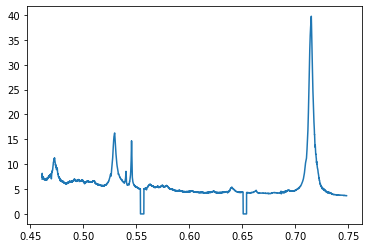

In [9]:
from q3dfit.common.makeqsotemplate import makeqsotemplate
makeqsotemplate(qsotempfits, outdir+'pg1411-qsotemplate.npy', wmapext=None, waveunit_in='Angstrom')
qsotemplate = outdir+'pg1411-qsotemplate.npy'

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [10]:
lines = ['Halpha', 'Hbeta', '[OI]6300', '[OI]6364', '[OIII]4959', '[OIII]5007', '[NII]6548', 
         '[NII]6583', '[SII]6716', '[SII]6731', '[NI]5198', '[NI]5200']

How many components do you want to be fitted to the emission lines?

In [11]:
maxncomp = 1

In [12]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = 'Halpha'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),0.0898)
    siginit_gas[i] = np.full(maxncomp,50.)
    zinit_stars=np.full((ncols,nrows),0.0898)

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globablly, for all spaxels and components, by defining a 2-element array. The limits can also be set for individual spaxels (but all components) by defining an (Ncol x Nrow x 2) array.

In [13]:
# Global limit
siglim_gas = np.array([5., 500.])

# Spaxel-by-spaxel limit
# siglim_gas = np.ndarray((dx, dy, 2))
# siglim_gas[:,:,] = array([5.,1000.])
# siglim_gas[13, 10, :] = array([5.,500.])

Description of continuum fitting parameters:
- `hostord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `hostord`. 0 < hostord < 4
- `qsoord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `qsoord`. 0 < hostord < 4

In [14]:
fcncontfit = 'fitqsohost'
argscontfit = dict()
argscontfit['qsoxdr'] = qsotemplate
argscontfit['siginit_stars'] = 50.
argscontfit['refit'] = 'ppxf'
argscontfit['blrpar'] = [0., 0.7150, 0.5000/299792.*0.7150,
                         0., 0.5300, 0.5000/299792.*0.5300]

#### 1.2.3. Line ratio constraints <a class="anchor" id="chapter1_2_3"></a>
`line1`, `line2`, and `comp` are required. `value` is the initial value of `line1`/`line2`, and `lower` and `upper` limits can also be specified. (If they are not, and the line pair is a doublet in the doublets.tbl file, then the lower and upper limits are set using the data in that file.) The ratio can also be `fixed`.

In [15]:
# Required columns:
line1 = ['[NI]5198']
line2 = ['[NI]5200']
comp = np.array([0], dtype=np.int32)

# Optional columns:
value = [1.5]
fixed = [True]
# lower = []
# upper = []

# Write table
from astropy.table import QTable
lineratio = QTable([line1, line2, comp, value, fixed], names=['line1', 'line2', 'comp', 'value', 'fixed'])

#### 1.2.4. Wavelength-dependent spectral convolution <a class="anchor" id="chapter1_2_4"></a>
If no convolution is desired, then set `spectres_convolve` to None.  
If convolution is desired, then `spectres_convolve` and `spect_instrum` are required. 
Specify the desired convolution method as the dictionary key, which should mirror the filename in /data/dispersion_files, and the dictionary elements should specify the grating, spectral resolution, or velocity.

e.g. to convolve spectrum with JWST NIRSPEC / G140M, then set `spect_instrum = {'JWST_NIRSPEC':['G140M']}`

In [16]:
spect_instrum = {'flat':['R4666']}
spectres_convolve = {'ws_instrum':spect_instrum}

### 1.3. Setting up the plotting parameters <a class="anchor" id="chapter1_3"></a>

One dictionary must be defined for a line plot to appear. `argspltlin1` holds the options for the first line plot, and `argspltlin2` is for the second. Parameter options are fed in as keyword/data pairs.

Required keywords in each dictionary:
* `nx`: Number of subplots in the horizontal direction
* `ny`: Number of subplots in the vertical direction
* Options for centerting the plot:
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame

Optional keywords:
* `size`: float list of widths in wavelength space of each subplot; if not specified, default is 300 $Å$
* `IR`: set to `True` to use infrared-style plot

In [17]:
argspltlin1 = {'nx': 3,
               'ny': 2,
               'line': ['Hbeta', '[OIII]4959', '[NI]5200', '[OI]6300', 'Halpha', '[SII]6716'],
               'size': [0.01, 0.0125, 0.01, 0.0125, 0.0100, 0.0100]}

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [18]:
q3di = { \
        # Required pars
        'fitran': fitrange,
        'fluxunits': 1e-15,
        'infile': infile,
        'label': gal,
        'lines': lines,
        'linetie': linetie,
        'maxncomp': maxncomp,
        'name': 'PG1411+442',
        'ncomp': ncomp,
        'outdir': outdir,
        'zinit_stars': zinit_stars,
        'zinit_gas': zinit_gas,
        'zsys_gas': 0.0898,
        'spect_convol':spectres_convolve,
        # Optional pars
        'argscheckcomp': {'sigcut': 3,
                          'ignore': ['[OI]6300', '[OI]6364',
                                     '[NI]5198', '[NI]5200'
                                     '[SII]6716', '[SII]6731']},
        'fcncontfit': fcncontfit,
        'argscontfit': argscontfit,
        'argscontplot': {'xstyle': 'lin',
                         'ystyle': 'lin',
                         'waveunit_out': 'Angstrom',
                         'fluxunit_in': 'flambda',
                         'fluxunit_out': 'flambda',
                         'mode': 'dark'},
        'argsinitpar': {'lineratio': lineratio},
        'argsreadcube': argsreadcube,
        'argslinelist': {'vacuum': False},
        # 'argslinefit': {'x_scale': 'jac'},
        'startempfile': stellartemplates,
        'argspltlin1': argspltlin1,
        'decompose_qso_fit': 1,
        # 'remove_scattered': 1,
        'fcncheckcomp': 'checkcomp',
        'maskwidths_def': 500.,
        'emlsigcut': 2,
        'logfile': logfile,
        'siglim_gas': siglim_gas,
        'siginit_gas': siginit_gas,
        'siginit_stars': 50.,
        'cutrange': np.array([0.6410, 0.6430]),
        'nocvdf': 1,
    }

If you want to run `q3dfit` in batch mode, run this cell, which saves q3di to an `npy` file. In your python command line, read in file and run `q3dfit` with
<pre><code>q3di = '/path/to/the/npy/file/q3di.npy'
from q3dfit.common.q3df import q3df
q3df(q3di,cols=cols,rows=rows)</code></pre>

In [19]:
q3di_npy = 'q3di.npy'
np.save(path_to_npy_file+q3di_npy,q3di)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [20]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [21]:
cols = [14]
rows = [11]

In [22]:
q3df(q3di,cols=cols,rows=rows)

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

Inline plotting:

CUBE: Negative values encountered in variance array. Taking absolute value.


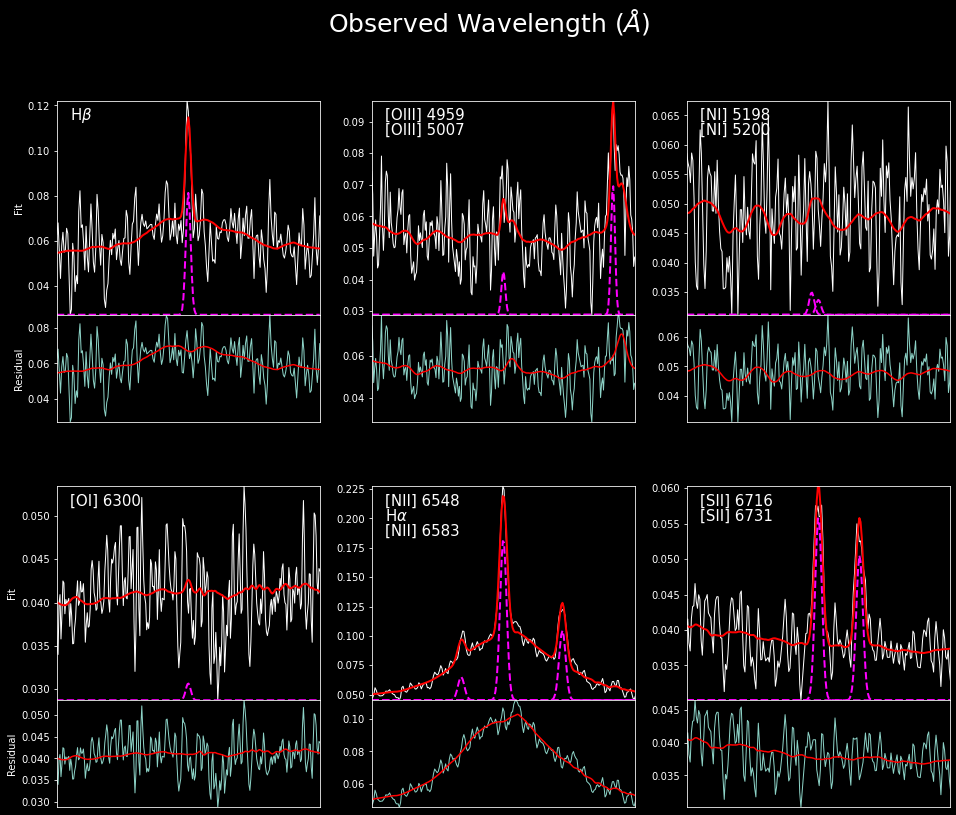

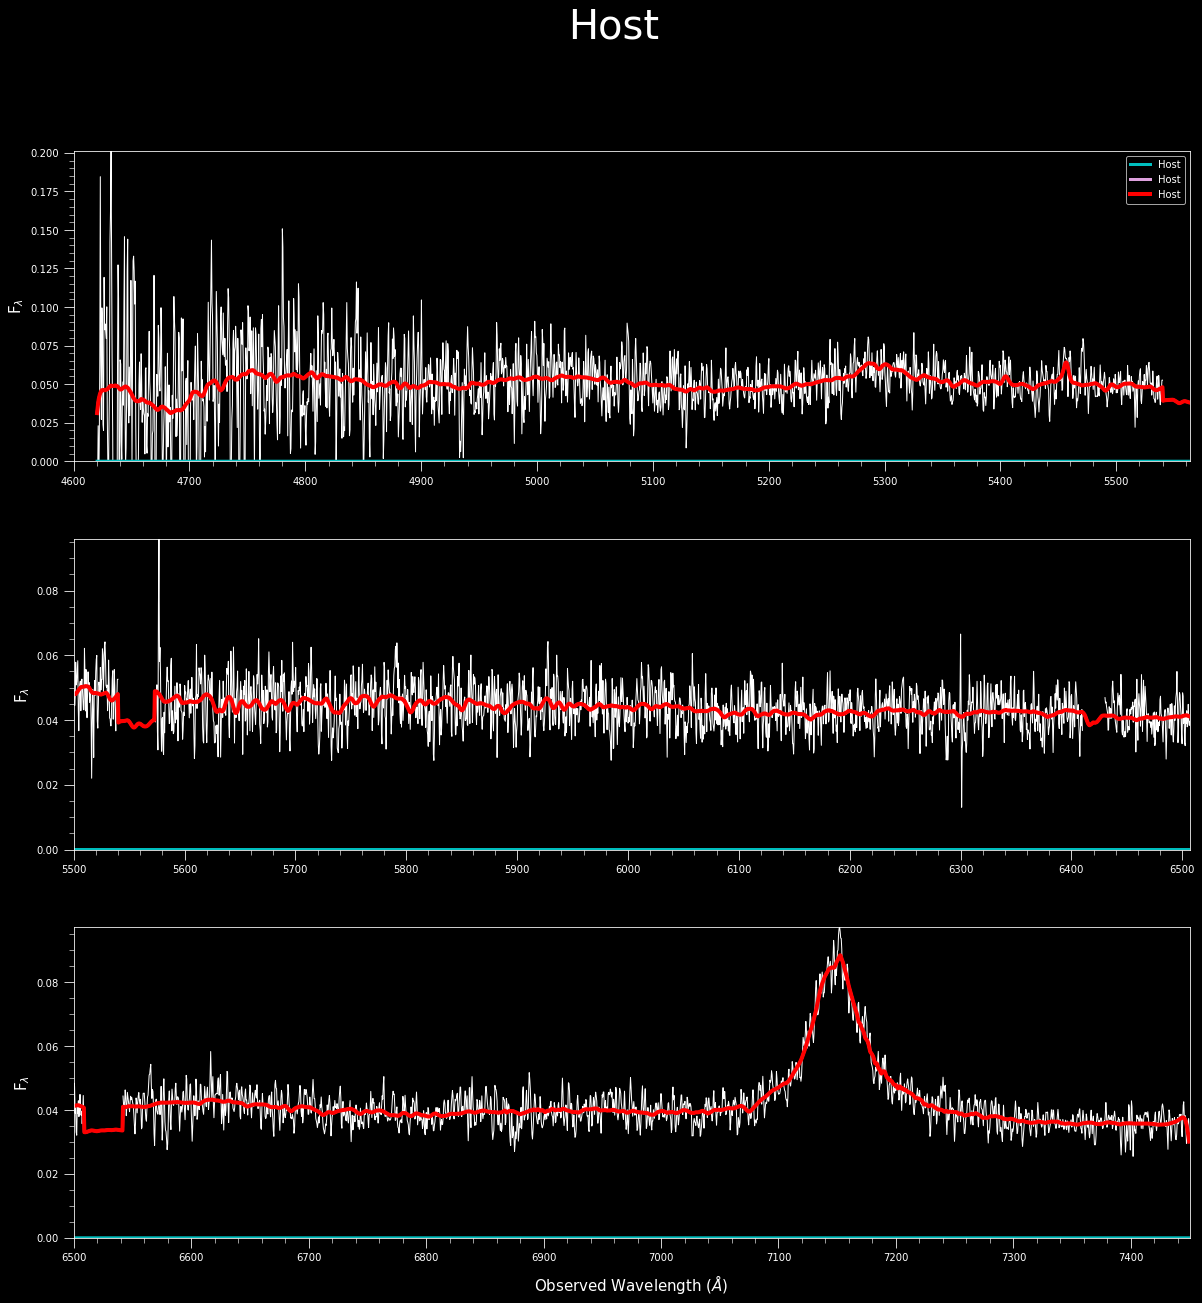

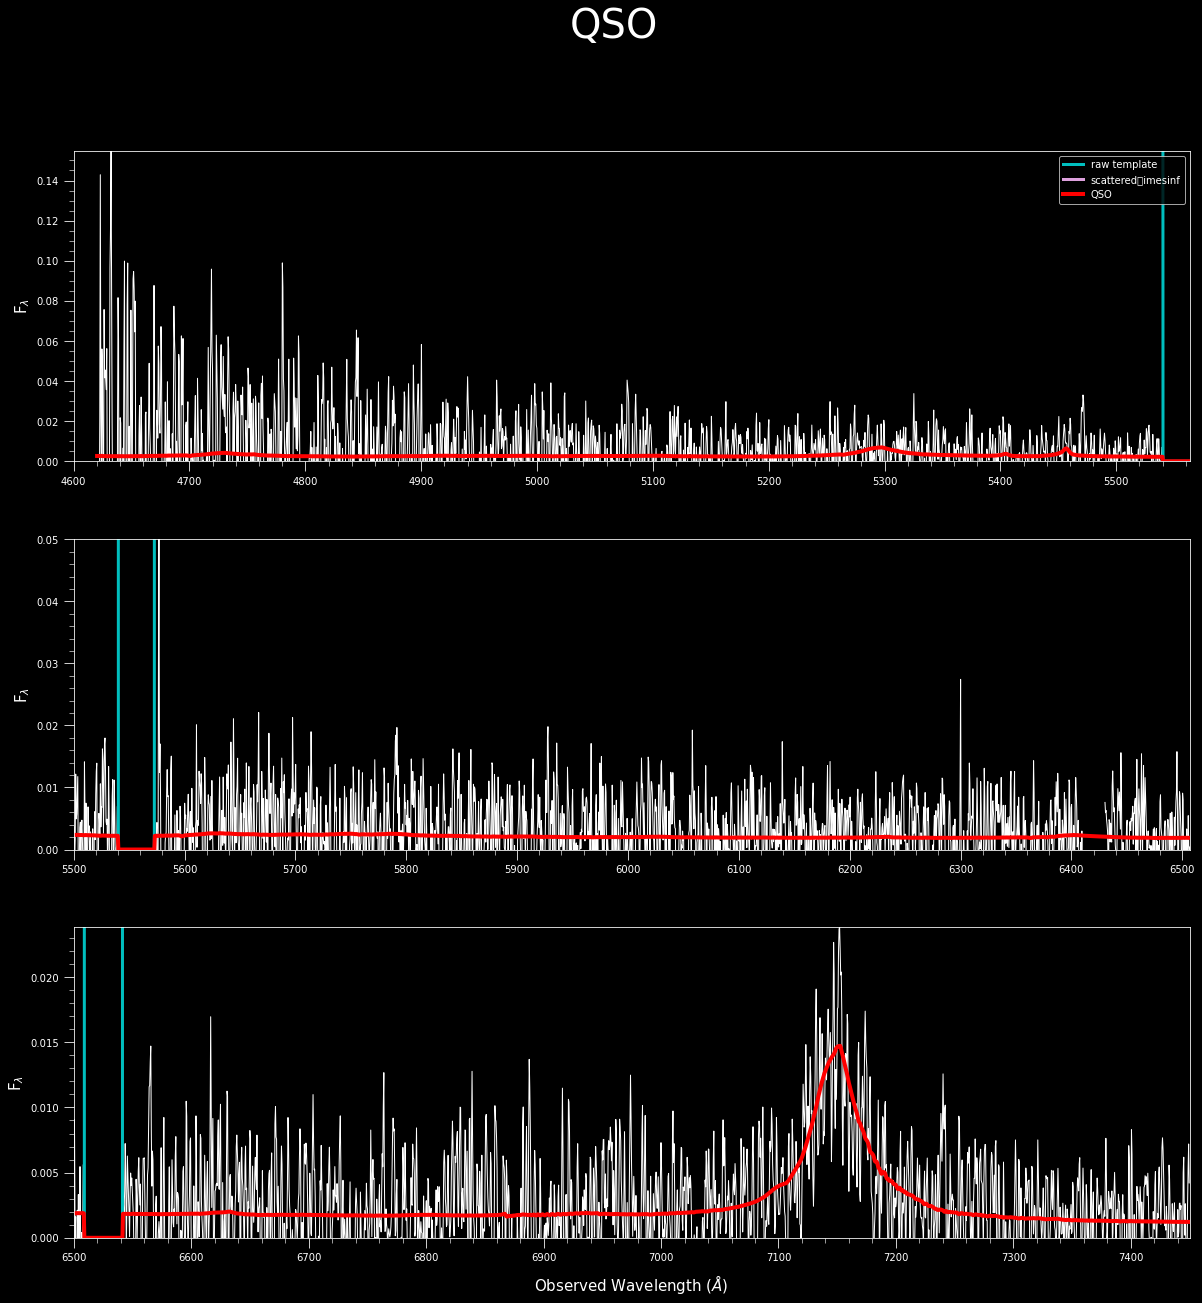

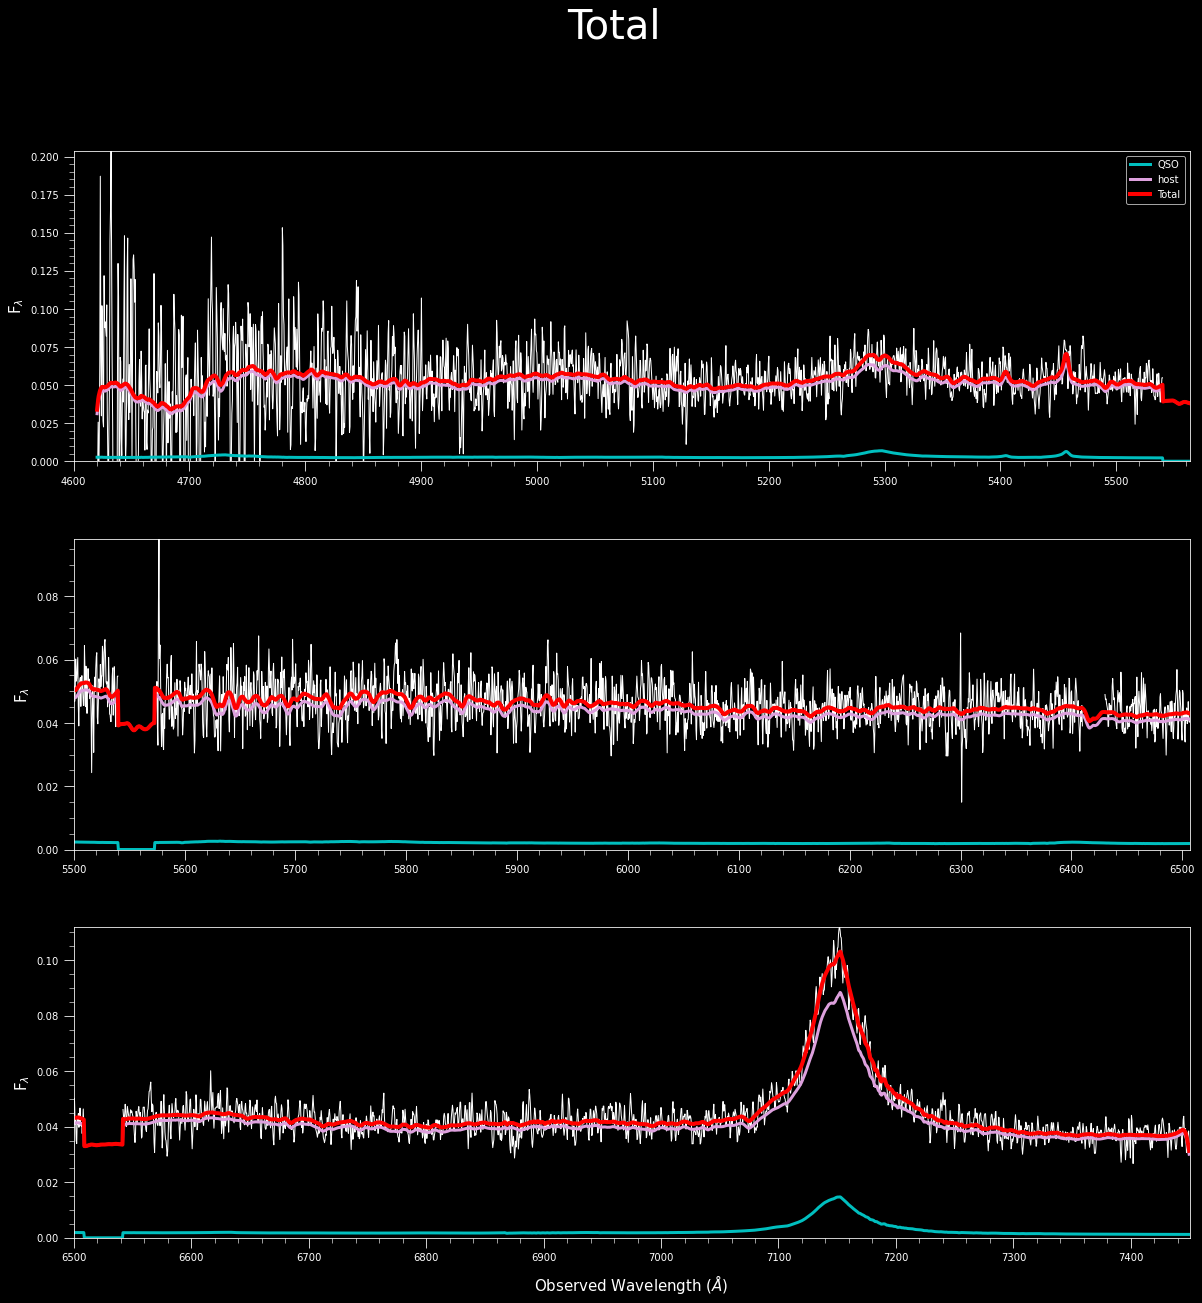

In [24]:
%matplotlib inline
q3da(q3di,cols=cols,rows=rows)

Plots in an external, interactive window:

In [25]:
%matplotlib
q3da(q3di,cols=cols,rows=rows)

Using matplotlib backend: <object object at 0x7fac3aa15c60>
CUBE: Negative values encountered in variance array. Taking absolute value.
